# JPEG assignment
In this Notebook, I will try to design a JPEG encoder/decoder with a set of defined spec. The sequence of the notebook is as follows:
1. Preliminaries: Some basic JPEG helper functions. These will include the DCT/IDCT, runlength code and Huffman code
2. Create a JPEG encoder/decoder that takes the quantization table as a parameter
3. Specify the required specs: mainly compression ratio and image quality
4. Try to maniputate the quantization table to meet the specs (compression ratio and image quality are conflicting so there will be a tradeoff)

## Preliminaries.
I will use following 2 block diagram as my guide

<img src = "../images/jpeg_encoding.jpg" width=600>

<img src = "../images/jpeg_decoding.jpg" width = 600>

In this section I will try to build some of the basic blocks of the JPEG algorithm. The rest will be in the following sections <br>
I will try to build
- DCT/IDCT function
- Division by quantization table function
- A function to return the order of indices of ZigZag pattern
- Runlength encoder/decoder
- Huffman encoder/decoder

In [2]:
import numpy as np
from scipy.fft import dct
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### 1D DCT as matrix multiplication

 The fomrmula for the 1D DCT is, where $g(x)$ is the time/spatial domain signal, and $G(m)$ is the DCT
 
 $$
G(m)= \sum_{x=0}^{M-1} g(x) \cdot \cos \left(\pi \frac{m(2 x+1)}{2 M}\right)
$$

We already know that, when mapping to an orthogonal basis, like DCT bases, we correlate our signal with each basis to find the corresponding coefficient in the other domain. Like the following: <br><br>
<img src = "../images/basis_corr.jpg" width = 600> <br>

We can loop over all basis functions, using a for loop. However, the process of multiplying and adding is the very definition of matrix multiplication.<br>

So, if we stack our basis functions in a matrix, row by row, and multiply this matrix by our input vector, the output will be a vector, which is the DCT coefficients!

This can be shown in the following image: The direction of the arrow shows the order of mutiplication <br><br>
<img src = "../images/mat_mult.jpg" width = 600> <br>

We can also observe that the only thing changing in the cosine basis formula is the product `(m (2x+1))`, where 
- m is the order of the basis
- x is the sample position in the original signal <br>

So, the values of `(m (2x+1)` in the cosine basis can be the outcome of a simple outer product as shown in the following :
<br> <br>
<img src = "../images/dct_matrix.jpg" width = 600>
<br>
Now we can define a function that returns this Transformation matrix. <br>

In [3]:
def get_DCT_matrix(size):
    '''Returns the normalised square matrix, used in the computation of the Discrete Cosine Transform
    
    Argument:
    size: the size of the matrix, which is the size of each basis vector. This must be equal to the length 
            of the signal to be transformed, obviously
    
    Returns:
    DCT_matrix: The required DCT matrix
    '''
    # initializing x and m
    x = np.arange(start = 0, stop = size).reshape(1, size) # row vector
    x = 2*x+1
    m = np.arange(start = 0, stop = size).reshape(size, 1) # column vector
    
    # the outer product
    matrix = np.dot(m,x)
    
    # taking the cosine
    DCT_matrix = np.cos(matrix* np.pi /2 / size)
    
    # normalizing, dividing each basis by its magnitude
    #DCT_matrix[0, :] *= np.sqrt(1/size)
    #DCT_matrix[1:,:] *= np.sqrt(2/size)
    
    return DCT_matrix

#### We can define a global variable for the DCT matrix. We don't need to compute the DCT matrix everytime we compute the DCT ceofficients 

In [4]:
DCT_MATRIX = get_DCT_matrix(8)
# where our image blocks are 8x8

### 2D Discrete Cosine Transform
The equation for the 2D DCT is
$$
G(m,n)= \sum_{x=0}^{M-1}\sum_{y=0}^{N-1} g(x,y) \cdot \cos \left(\pi \frac{m(2 x+1)}{2 M}\right)\cdot \cos \left(\pi \frac{m(2 y+1)}{2 N}\right)
$$
From the equation, we can see that we can perform 2D DCT using the 1D DCT, where, we can view the 2D equation as:
- fix the rows (columns), and iterate over the columns (rows), this will yield the 1D DCT of the rows (columns)
- store that in an intermediate matrix
- fix the columns (rows) of the intermediate matrix, and iterate over its rows (columns), this will yield the 1D DCT of the columns (rows)
- The result is the 2D DCT

#### Now, we can compute the 2D DCT easily as <br>
 $$
 DCT \space matrix_1 \times image \space block \times DCT\space matrix_2 ^T 
 $$ <br>
 Where, 
 - The first matrix multiplication will apply the DCT on the columns
 - The second matrix multiplication will apply the DCT on the rows of the resulting matrix from the first matrix multiplication
 
 For our use case, the image blocks are square matrices of size 8x8, so the DCT matrix1 and DCT matrix2 are the same as our global variable `DCT_MATRIX`

In [5]:
def DCT_2D (in_block):
    '''computes the DCT transform of the incoming signal
    Arguments:
    in_block: the input 2D signal

    
    Returns:
    dct_coeff: The normalised DCT coefficients corresponding to this block
    '''
    
    # First some input validation
    row, col = in_block.shape
    assert (row == 8 and col == 8)
    
    #DCT computation
    Intermediate = np.dot(DCT_MATRIX, in_block)
    dct_coeff = np.dot(Intermediate, DCT_MATRIX.T)
    
    #scaling
    dct_coeff[0,0] /= 64
    dct_coeff[0,1:]/=32
    dct_coeff[1:,0] /= 32
    dct_coeff[1:,1:] /= 16
    
    return dct_coeff
    

### Now, the IDCT 2D
Using the same analogy in the DCT 2D, we can apply the IDCT equation using matrix multiplications. <br>
The IDCT equation: 
$$
g(x)=\cdot \sum_{m=0}^{M-1} G(m) \cdot \cos \left(\pi \frac{m(2 x+1)}{2 M}\right)
$$
Contrasting this with the DCT equation, we observe that the summation index, is interchanged. This corresponds to Transposing the DCT matrix! <br> <br>
<img src = "../images/idct_matrix.jpg" width = 600>

Therefore the IDCT 2D is simply as follows

$$
DCT\space Matrix^T \times DCTcoefficients \times DCT\space Matrix
$$


In [6]:
def IDCT_2D(in_block):
    '''computes the IDCT transform of the incoming DCT coefficients block
    Arguments:
    in_block: the input 2D DCT coefficients

    
    Returns:
    inverted: The result of the IDCT
    '''
    # First some input validation
    row, col = in_block.shape
    assert (row == 8 and col == 8)
    
    #DCT computation
    
    Intermediate = np.dot(DCT_MATRIX.T, in_block)
    inverted = np.dot(Intermediate, DCT_MATRIX)
    
    return inverted
    

In [7]:
# testing the DCT/IDCT pair
# generate the array
x = np.random.randn(8,8)* 100
# generate the DCT matrix
big_x = DCT_2D(x)
# get the IDCT
ret_x = IDCT_2D(big_x)
# get the Sum of abs errors
error_2 = np.sum(abs(ret_x-x))
print("The sum of absolute errors is:",error_2)

The sum of absolute errors is: 3.582911745070305e-12


### Quantization "Source of lossy compression"
In this step, we divide each block's elements by a block called the `quantization table`. <br>
Rounding the result, this will yield a sparse matrix. <br>

This is the lossy part of the JPEG algorithm <br>
The Quantization table is our design target. Dividing by large numbers will lead to a higher compression ratio, but at the cost of quality. So, we will try to design one that meets the specs that will be defined later. <br>

We should note that images tend to have low amplitudes at high frequencies. This is why non-uniform quantization is a good strategy. In other words, we can sacrifice high frequncy content, without much affecting the image quality<br>

For now, I will setup the default quantization table as a block of ones. (i.e lossless... for now)



In [8]:
LOW_COMPRESSION_MAT = np.array([[1,1,1,1,1,2,2,4],
                                [1,1,1,1,1,2,2,4], 
                                [1,1,1,1,2,2,2,4], 
                                [1,1,1,1,2,2,4,8],
                                [1,1,2,2,2,2,4,8],
                                [2,2,2,2,2,4,8,8],
                                [2,2,2,4,4,8,8,16],
                                [4,4,4,4,8,8,16,16]
                               ])

HIGH_COMPRESSION_MAT = np.array([[1,2,4,8,16,32,64, 128],
                                 [2,4,4,8,16,32,64, 128],
                                 [4,4,8,16,32,64,128,128],
                                 [8,8,16,32,64,128,128,256],
                                 [16,16,32,64,128,128,256,256],
                                 [32,32,64,128,128,256,256,256],
                                 [64,64,128,128,256,256,256,256],
                                 [128,128,128,256,256,256,256,256]
                                ])
ONES_TABLE = np.ones((8,8))

In [9]:
def divide_quant(block, q_table = ONES_TABLE):
    '''Divides the each element in the block by the corresponding element in the Quantization table, then rounds
    
    Arguments:
    block: The block to be divided by the table
    q_table: The Quantization table "ones by default"
    
    Returns: The result of dividing, then rounding
    '''
    res = block / q_table
    res = res.astype(np.int) # rounding
    return res

In [10]:
# At the decoder, we multiply by the Q_table
def multiply_quant(block, q_table = ONES_TABLE):
    return block * q_table

### ZigZag Unrolling
In this step, we spread the 2D block into a 1D vector <br>
There are 3 important observations:
1. DCT coefficients represent increasing frequencies along the main diagonal as shown in the following image

<img src = "../images/incr_freq.jpg" width=400>

2. After the dividing by the quantization matrix, DCT coefficeints representing high frequencies tend to have small amplitudes. This is because visually, suppressing high frequency content does not affect the image quality much.

3. If we smarlty parse the matrix such that low frequency coefficients are parsed first, and high frequenciy coefficients are parsed last, we tend to have more continuous sequences of zeros. This sequence can then be compressed in a lossless way using `Run Length code`.

Becuase of these observations, we parse the matrix in a ZigZag fashion 
<img src="../images/zigzag.jpg" width = 400>

#### ZigZag indeces algorithm
In order to yield the DCT coefficients in the correct order, we can observe a pattern that will make life easier when coding.<br>
Imagine we are iterating over the integer range [0 to 7]
- if the iterator is odd, then we will move southwest on the matrix
- if the iterator is even, then we will move norhteaset on the matrix
<img src = "../images/zigzagalg.jpg" width = 400>

Doing so for all indeces, we can return the correct order of half the matrix elements

<img src = "../images/uppertriangle.jpg" width = 400>

##### What about the other half?
Well, they can be easily deduced from the first half!
For example, 
- the first three traversed elements have indeces : [0,0], [0,1], [1,0]
- the last three traversed elements, **reversed** have indeces: [7,7], [7,6], [6,7]

So the other half of indeces **reversed** are the same as the first half, after each dimension index is subtracted from 7



In [11]:
def get_ZigZag_indices(size):
    '''Returns the order of indeces to be parsed in zigzag parsing
    
    Arguments:
    size: The size of the square matrix to be parsed
    
    Returns:
    indeces: indeces ordered according to zigzag parsing
    '''
    
    # this will hold the first half
    indeces = []
    # this will hold the second half indeces
    reversed_indeces = []
    
    for i in range(size):
        for j in range(i+1):
            # if odd
            if i%2 != 0:
                indeces.append((j, i-j))
                reversed_indeces.append((size-1-j, size-1-i+j))
            # if even
            else:
                indeces.append((i-j, j))
                reversed_indeces.append((size-1-i+j,size-1-j))
    
    # reverse
    reversed_indeces = reversed_indeces[::-1]
    # exclude the main diagonal part because it is repeated
    indeces = indeces[:-size]
    # merge the two lists
    indeces.extend(reversed_indeces)
    
    return indeces

#### We can then define these indeces as a global variable to be used in rolling/unrolling 2D DCT matrices

In [12]:
# the ZIGZAG indices will be a global variable.
ZIG_ZAG_INDICES = get_ZigZag_indices(8)
ZIG_ZAG_ROW, ZIG_ZAG_COL = zip(* ZIG_ZAG_INDICES)

### RunLength Code "Lossless compression"
Now that we can parse the matrix such that there will be a greater chance for zeros to be in continuous sequences. We can compress the numbers using Run Length Code.<br>
For example, if we have a continuous sequence of `32 zeros`, we can compress them as `[0 32]` in just `2 numbers`, where the first number is a zero, and the second is how many times it occured in the continuous sequence

In [13]:
def encode_runlength(array):
    '''Returns the encoded array using runlength code
    The function will apply runlength to "0" because it is the most occuring element 
    
    Arguments:
    array: a 1D numpy array to be encoded
    
    Returns: a 1D list, encoded using runlength
    '''
    encoded = []
    counter = 0
    
    # this for loop will handle zeros that are interrupted before array ends
    for element in array:
        if (element == 0):                          #if element is zero, increment counter
            counter += 1
        else:                                       # if not, check if we were in a zero sequence
            if (counter != 0):
                # zero sequence interrupted
                encoded.extend([0, counter])
                # reset counter
                counter = 0
            
            # add the non zero element to the array 
            encoded.append(element)
            
    # This handles trailing zeros
    if counter != 0:
        encoded.extend([0, counter])
    return encoded

In [14]:
arr = np.random.randint(2, size = 10)
enc = encode_runlength(arr)
print("original array is", arr,"with length", len(arr))
print("encoded sequence is", enc, "with length", len(enc))

original array is [0 1 1 0 0 1 0 0 0 0] with length 10
encoded sequence is [0, 1, 1, 1, 0, 2, 1, 0, 4] with length 9


In [15]:
def decode_runlength(array):
    '''Decodes the runlength code of zeros
    Argument:
    array: a 1D numpy array of runlength code
    
    Returns: The original 1D sequence as a numpy array
    '''
    decoded = []
    index = 0
    while index < len(array):
        if array[index] == 0:                # zero detected
            count = array[index+1]
            # recreate the zero sequence
            zero_seq = [0]*count
            # append the zero sequence
            decoded.extend(zero_seq)
            # update the index by 2 to bypass the count
            index+=2
        else:                               # not a zero
            decoded.append(array[index])
            index += 1
    return np.array(decoded)

In [16]:
dec = decode_runlength(enc)
print("The decoded sequence is", dec)
print("Is the decoded the same as the original? ")
all(dec == arr)

The decoded sequence is [0 1 1 0 0 1 0 0 0 0]
Is the decoded the same as the original? 


True

### Entropy code "Lossless compression"
Now that we have our 1D vector of runlength code, we can compress it even further using entropy code, like Huffman code. <br>
Huffman code is a variable length code scheme that assigns less bits to more frequent symbols. In effect, it reduces the average length of the code word, and brings it closer to the entropy of the symbols. <br>

One might think that it is uselss to use Huffman code for arbitrary numbers that are most likely equiprobable.<br>
This is not true. <br>
Grayscale images have pixel values between [0 255], so the DCT coefficients of 8x8 blocks are **bounded**. Dividing by  Quantization tables and rounding also makes some symbols more frequent than others, so our alphabet is effectively shorter<br>

For Huffman code, we need to
1. calculate the probability of each symbol
2. Construct the Huffman tree
3. Encode the incoming stream

For Decoding, we will just use the Huffman tree.<br>

#### I will use the code we used for phase I of the project, with some modifications to work for numerical symbols. To avoid crowdedness, I will write the class and the methods in a utility file `utils.py`

In [17]:
from utils import *

##### Demonstrating

In [18]:
array = [0,0,0,1,1,2,1]

encoded_str, huff_tree, huff_dict, symbo_dict = encode_huffman(array)
huff_tree.display()

                                ______________________________1.0___________           
                               /                                            \          
            __________0.5714285714285714___________              1: 0.42857142857142855
           /                                       \                                   
0: 0.42857142857142855                  2: 0.14285714285714285                         


In [19]:
decode_huffman(encoded_str, huff_tree)

[0, 0, 0, 1, 1, 2, 1]

##### So it works. 

##### That's it for the preliminaries. Time to encode and decode images!

# JPEG Encoding

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Reading the image

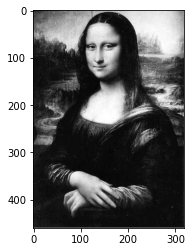

In [22]:
img_path = "../images/monalisa.jpg"
image =  mpimg.imread(img_path)
plt.imshow(image, cmap = "gray");

In [23]:
print("The image size is", image.shape)

The image size is (460, 318)


### Blocks of 8x8
For this I will divide the image into a list of blocks<br>
We will need to zero pad the image if we can't have an integer number of blocks

In [24]:
def pad_image(image):
    '''Zero pads the image if necessary to be composed of 8x8 blocks
    
    Arguments: 
    image: a 2D numpy matrix 
    
    Returns:
    padded_image: a padded image with both dimensions as multiples of 8
    '''
    
    #initializing the padded dims to rows and cols
    row_padded, col_padded = image.shape
    
    #padding the rows if they are not multiples of 8
    if (row_padded % 8 != 0):
        row_padded = row_padded + (8 - row_padded % 8)
    #padding the cols 
    if (col_padded % 8 != 0):
        col_padded = col_padded + (8 - col_padded % 8)
    
    # if no padding happened, return the original image
    if (row_padded, col_padded) == image.shape:
        return image
    
    (row, col) = image.shape
    # initialize with new dims
    padded_image = np.zeros((row_padded, col_padded))
    
    # assign the old image to its right place
    padded_image[0:row, 0:col] = image
    
    return padded_image

Then, I will divide the blocks into an array, where each block will be processed separately

In [25]:
def blockify(image):
    '''Returns a list of image blocks
    Arguments:
    image: a 2D matrix representing a matrix
    
    Returns
    blocks: a list of 8x8 blocks
    '''
    # zero pad if necessary
    image_padded = pad_image(image)
    # initialize the blocks list
    blocks = []
    # find out the number of blocks across each dim
    row, col = image_padded.shape
    n_block_row = int(row/8)
    n_block_col = int(col/8)
    # unenroll
    for i in range(n_block_row):
        for j in range(n_block_col):
            current_block = image_padded[i*8: (i+1)*8, j*8: (j+1)*8]
            blocks.append(current_block)
    
    return blocks, image_padded.shape

In [26]:
blocks, _ = blockify(image)
blocks[0]

array([[62., 59., 56., 53., 55., 56., 52., 46.],
       [62., 60., 55., 52., 52., 54., 51., 46.],
       [64., 62., 57., 51., 51., 54., 53., 48.],
       [65., 65., 59., 52., 52., 58., 58., 54.],
       [63., 65., 61., 52., 52., 60., 63., 58.],
       [63., 67., 64., 54., 53., 62., 65., 60.],
       [67., 74., 70., 59., 57., 66., 68., 62.],
       [74., 81., 77., 65., 62., 70., 71., 64.]])

## 2. Apply DCT to each block

In [27]:
DCT_blocks = []
for block in blocks:
    DCT_blocks.append(DCT_2D(block))
DCT_blocks[0]

array([[ 5.97343750e+01,  4.21865652e+00,  2.90148625e+00,
         1.16183157e+00, -3.60182517e+00,  4.96412217e-02,
         1.79684858e-02, -3.17957562e-02],
       [-7.09610186e+00,  1.27281171e+00, -1.52161091e+00,
         1.95042283e+00,  2.54216815e+00,  6.51387418e-02,
         8.11859328e-02,  1.11320746e-01],
       [ 2.22839068e+00,  1.25321333e+00, -1.53634222e+00,
         8.25675722e-02, -1.69123781e-02, -7.52974239e-02,
        -2.20970869e-02, -2.78452218e-02],
       [-1.03098488e+00, -1.72263182e+00, -6.32318480e-02,
        -5.51744033e-02, -8.87920453e-02,  9.95578800e-02,
         8.82251863e-02,  1.28123434e-01],
       [ 1.25953395e+00,  4.48933117e-02, -1.69123781e-02,
         1.65943155e-01, -3.12500000e-02, -3.30081459e-02,
         4.08300927e-02,  6.71875890e-02],
       [ 4.04587562e-02,  1.33425641e-02, -2.19098258e-02,
         7.36695323e-02, -2.55222803e-02, -1.15320726e-01,
         3.36744455e-02, -7.94252058e-03],
       [ 9.76122370e-03,  1.482068

## 3. Applying quantization
Let's try the high compression first

In [28]:
q_blocks = []
for block in DCT_blocks:
    q_blocks.append(divide_quant(block))
q_blocks[0]

array([[59,  4,  2,  1, -3,  0,  0,  0],
       [-7,  1, -1,  1,  2,  0,  0,  0],
       [ 2,  1, -1,  0,  0,  0,  0,  0],
       [-1, -1,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

## 4. Unrolling each block into a vector

In [29]:
unrolled = []
for block in q_blocks:
    vector = block[ZIG_ZAG_ROW, ZIG_ZAG_COL]
    unrolled.append(vector)
unrolled[0]

array([59,  4, -7,  2,  1,  2,  1, -1,  1, -1,  1, -1, -1,  1, -3,  0,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

## 5. Applying runlength code

In [30]:
rn_coded = []
for vector in unrolled:
    rn_coded.append(encode_runlength(vector))
rn_coded[0]

[59, 4, -7, 2, 1, 2, 1, -1, 1, -1, 1, -1, -1, 1, -3, 0, 1, 2, 0, 47]

## 6. Applying Huffman code on the entire stream 


In [31]:
# obtaining the stream
stream = []
for rn in rn_coded:
    stream.extend(rn)

In [32]:
# applying huffman
huff_stream, huff_tree, huff_dict, symb_dict = encode_huffman(stream)

In [33]:
# printing the first 100 elements
huff_stream[0:100]

'0011100100100000001101110110111011010101101010110101010101101000101110111001100110010000111010011010'

### We can gather all of this in a single function

In [34]:
def encode_JPEG(image, q_table = ONES_TABLE):
    '''Performs JPEG compression on the image
    
    Arguments:
    image: a 2D matrix representing the grayscale image
    q_table: The qunatization table used while compressing
    
    Returns:
    huff_stream: The stream of bits obtained from the Huffman encoding
    huff_tree: The tree that holds the coding scheme. Essential for decoding
    huff_dict: A dictionary which maps each symbol to its assigned code by the Huffman code
    padded_shape: The size of the padded image. Will be usefull for reconstructing the image
    '''
    # dividing into blocks
    blocks, padded_shape = blockify(image)
    
    # initializing the stream
    stream = []
    # for each block
    for block in blocks:
        # applying 2D DCT
        DCT_block = DCT_2D(block)
        
        # dividing by quantization matrix
        q_block = divide_quant(DCT_block, q_table)
        
        # zigzag unrolling or spreading
        vector = q_block[ZIG_ZAG_ROW, ZIG_ZAG_COL]
        
        # Runlength
        rn_vector = encode_runlength(vector)
        
        # appending to stream
        stream.extend(rn_vector)
    
    # Now that we have the stream, apply huffman encoding
    huff_stream, huff_tree, huff_dict, symb_dict = encode_huffman(stream)
    
    return huff_stream, huff_tree, huff_dict, symb_dict, padded_shape

In [37]:
hf_stream, hf_tree, hf_dict, symbol_dict, image_dims = encode_JPEG(image)
len(hf_stream)

281055

In [39]:
print("Compression ratio is {}".format(image.shape[0] * image.shape[1] * 8 / len(hf_stream)))

Compression ratio is 4.163740193200619


# JPEG Decoder

## 7. Huffman Decoding
We will use the huffman tree we obtained earlier

In [40]:
decoded_hf_stream = decode_huffman(hf_stream, hf_tree)

## 8. RunLength Decoding 

In [41]:
decoded_rn_stream = decode_runlength(decoded_hf_stream)

## 9. ZigZag rolling
For every 64 elements obtained from the decoded run length, we can obtain the corresponding matrix

In [42]:
# separate every 64 element
vectors = []
n_vec = int(len(decoded_rn_stream) / 64)
for vec_index in range(n_vec):
    vector = decoded_rn_stream[vec_index * 64: (vec_index+1)*64]
    vectors.append(vector)

In [43]:
# roll each vector in a 2D matrix
blocks = []
for vector in vectors:
    rolled = np.empty((8,8))
    rolled[ZIG_ZAG_ROW, ZIG_ZAG_COL] = vector
    blocks.append(rolled)


## 10. Multiply by Quantization Table

In [44]:
qt_blocks = []
for block in blocks:
    qt_blocks.append(block * ONES_TABLE)
    

## 11. IDCT

In [45]:
ret_blocks = []
for block in qt_blocks:
    ret_blocks.append(IDCT_2D(block))

In [46]:
image_dims

(464, 320)

## 11 & 12.  IDCT and combining the image

In [47]:
regrouped = np.empty(image_dims)
n_block_col = int(image_dims[1]/8)
for index, block in enumerate(qt_blocks):
    row_index = int(index/n_block_col)
    col_index = index%n_block_col
    regrouped[row_index*8: (row_index+1)*8, col_index*8: (col_index+1)*8] = IDCT_2D(block)

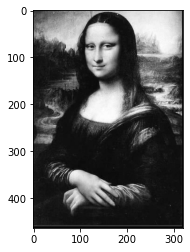

In [48]:
plt.imshow(regrouped, cmap="gray");

#### We can combine all of that in a single function 

In [49]:
def decode_jpeg(hf_stream, hf_tree, image_dims, q_table = ONES_TABLE):
    '''Decodes a Huffman stream into a 2D representation of grayscale image
    Arguments:
    hf_stream: The Stream of bits obtained from huffman code
    hf_tree: The Huffman tree to be used in decoding
    image_dims: The dimension of the image to be decoded
    q_table: The qunatization table that will be multipllied by each block before IDCT
    
    Returns:
    ret_image: The 2D decoded image
    '''
    # init the returned image
    ret_image = np.empty(image_dims)
    
    # The number of blocks along the columns
    n_block_col = int(image_dims[1]/8)
    
    # decode the huffman stream
    dec_hf = decode_huffman(hf_stream, hf_tree)
    
    # runlength decode
    dec_rn = decode_runlength(dec_hf)
    
    # Divide the decoded runlength into chunks of 64 elements
    # each rolled chunk will be multiplied by q_table and grouped into a decoded image
    n_chunks = int(len(dec_rn)/64)
    
    for i in range(n_chunks):
        chunk = dec_rn[i * 64: (i+1)*64]
        
        # roll it into a 2D matrix
        rolled = np.empty((8,8))
        rolled[ZIG_ZAG_ROW, ZIG_ZAG_COL] = chunk
        
        # multiply by q_table
        rolled = rolled * q_table
        
        # IDCT and grouping
        row_index = int(i/n_block_col)
        col_index = i %n_block_col
        ret_image[row_index*8: (row_index+1)*8, col_index*8: (col_index+1)*8] = IDCT_2D(rolled)
    
    return ret_image

In [50]:
h_stream, h_tree, h_dict, sym_dict, dims = encode_JPEG(image, q_table=LOW_COMPRESSION_MAT)
dec = decode_jpeg(h_stream, h_tree, dims, q_table=LOW_COMPRESSION_MAT)

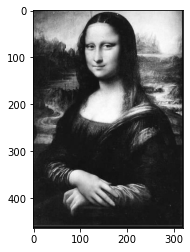

In [51]:
plt.imshow(dec, cmap="gray");

# Now That the JPEG Encoder / Decoder works, time for Specs definition

## Compression Ratio
After searching online for conventional compression ratios, using [this link as reference](https://ntrs.nasa.gov/citations/19920024689) which wikipedia cites,<br> it looks like `10:1` is an acceptable ratio

## Quality After compression
The quality after compression can be inspected by the RMSE between the image and the decoded image
I will set the image quality spec as:<br> RMSE < 5

## Testing different quantization tables on a Full HD image
First we want to convert it to grayscale

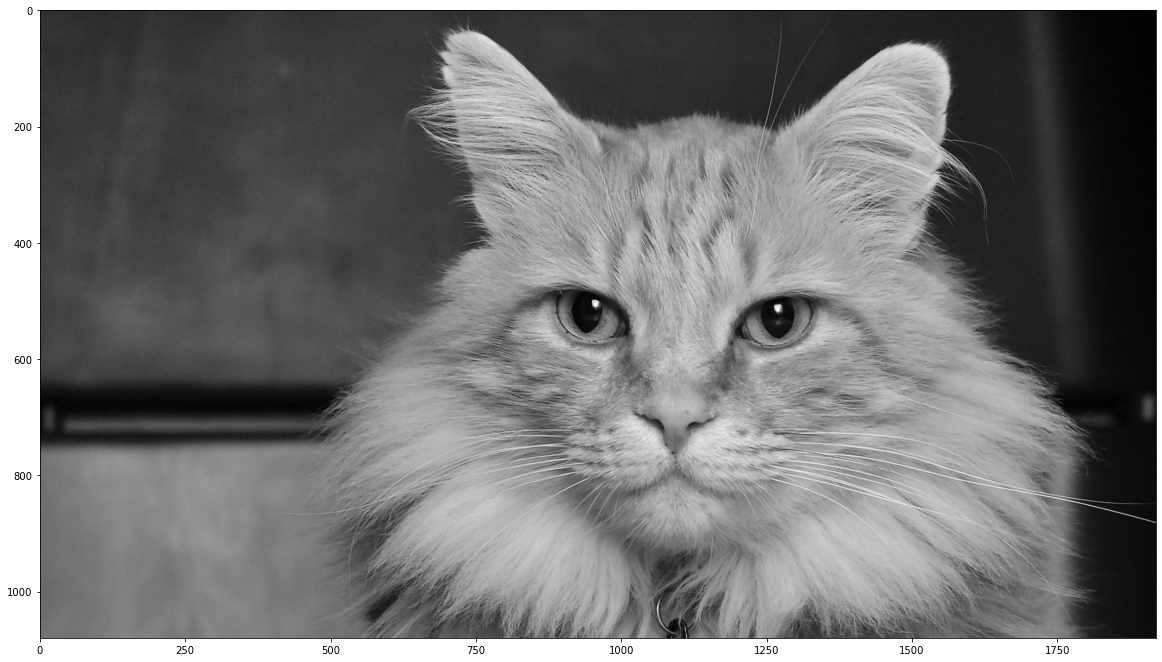

In [54]:
from PIL import Image
# converting it to grayscale 
hd_image = Image.open("../images/full_hd.jpg").convert("L")
hd_image = np.array(hd_image)
# Now we save it for reference
gray_hd = Image.fromarray(hd_image)
gray_hd.save("../Original_HD_grayscale.jpeg")
# Now we display it
plt.figure(figsize=(20,20))
plt.imshow(hd_image, cmap = "gray");

Now, we want to design a qunatization table that meets those specs. We can start from the tables we defined earlier
- `HIGH_COMPRESSION_MAT`has higher values, so more quantization loss
- `LOW_COMPRESSION_MAT` has lower values, so less quantization loss
- `ONES_MAT` "lossless compression"

In order to calculate the compression ratio, we will do the following ratio:

$$
\frac{number\space of\space pixels \times 8}{number\space of\space bits\space in\space huffman\space code}
$$

Since each pixel has one of 256 values, so each is encoded using 8 bits

In [55]:
import time

### Ones Matrix

The code took 4.998698472976685 seconds
Compression ratio is 6.766210713166963
The RMSE is 1.1729693392130323


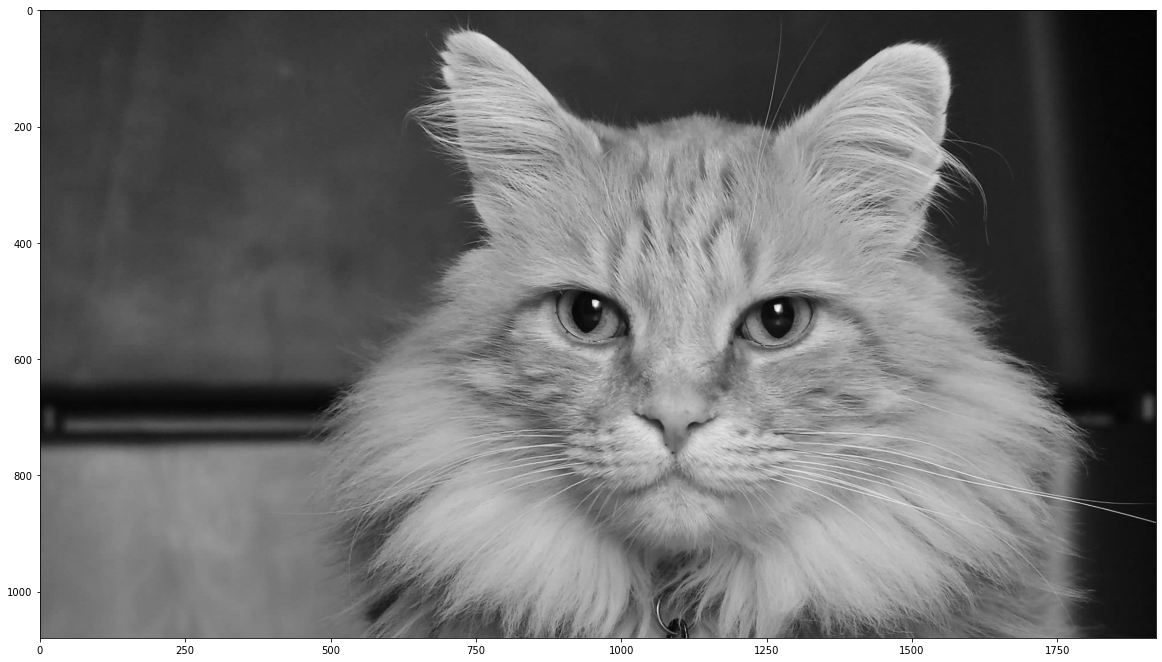

In [56]:
t = time.time()
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table=ONES_TABLE)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)

t =  time.time() - t
print("The code took {} seconds".format(t))
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(20,20))
plt.imshow(ret_image, cmap ="gray");

- The RMSE is not zero probably due to precision errors. It should be zero, becuase there are no quantization erros
- The Image visually is very similar to the original "no visible artefacts"
- The compression ratio doesn't meet our specs as well.

### High Compression Matrix

Compression ratio is 18.36730626570856
The RMSE is 7.948597076401691


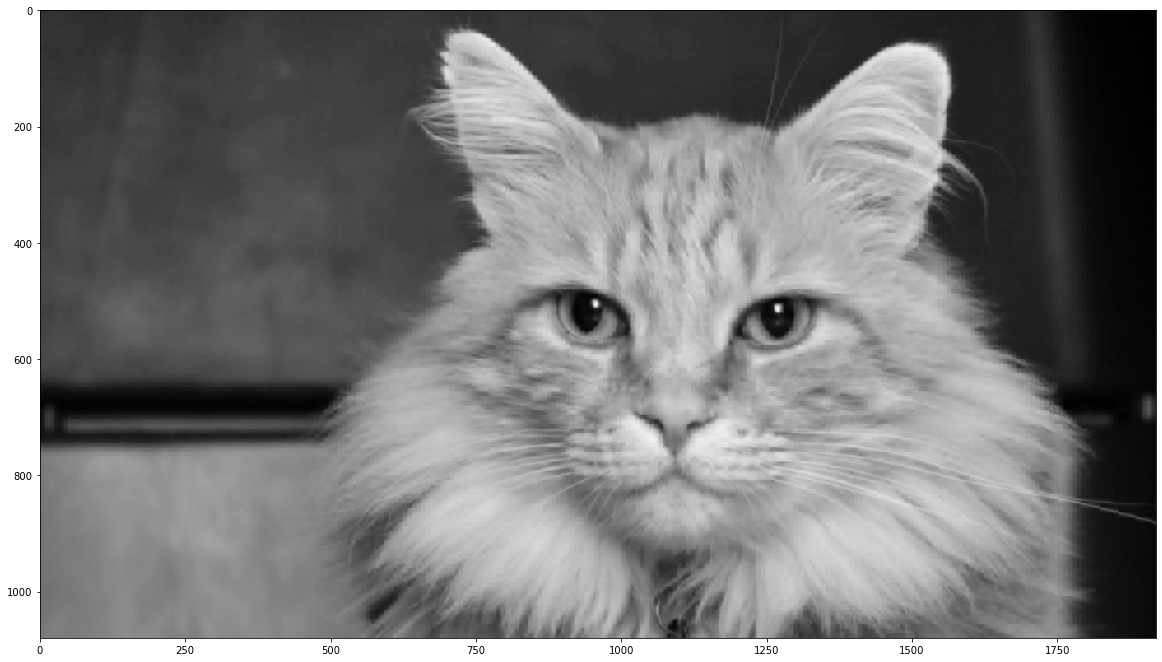

In [57]:
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table=HIGH_COMPRESSION_MAT)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(20,20))
plt.imshow(ret_image, cmap ="gray");

- The compression ratio is very good! 
- But, The artefacts are indded visible. Image quality has visibly decreased
- RMSE is 7.9, which is not in our specs

### Low Compression Matrix

Compression ratio is 6.9475453790455415
The RMSE is 2.1762301562978457


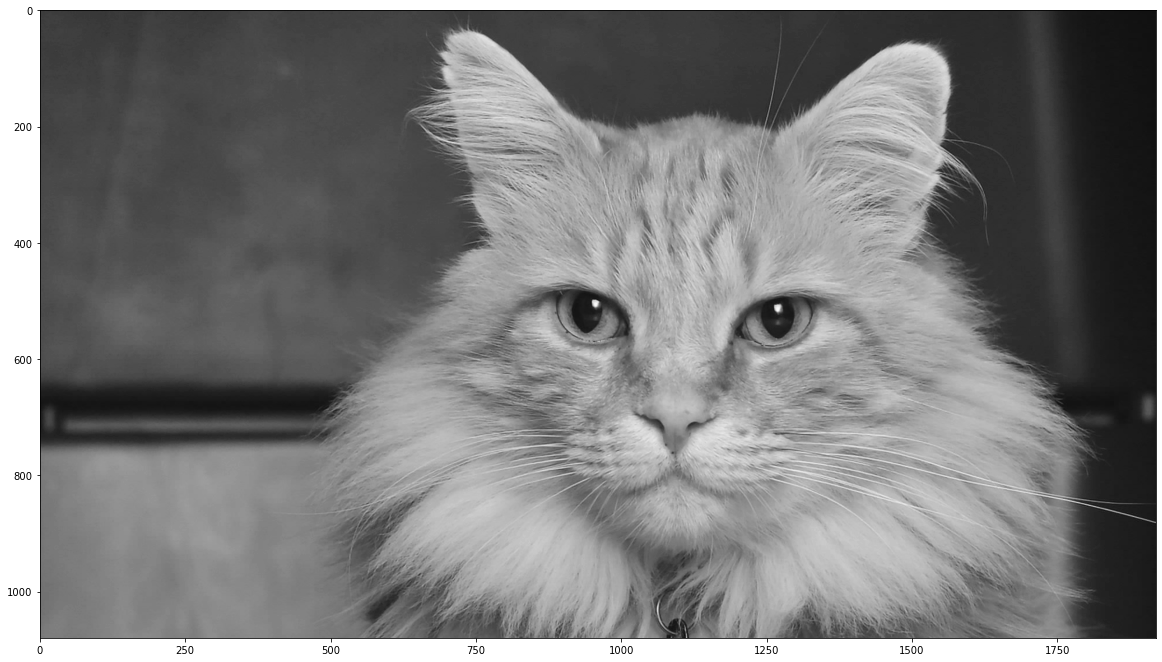

In [58]:
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table=LOW_COMPRESSION_MAT)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(20,20))
plt.imshow(ret_image, cmap ="gray");

- The Compression Ratio doesn't meet our specs
- There are no visible artefacts, so visually the image is good
- RMSE is within our specs

## So, it appears none of these tables is within our specs. I will try to design one on my own based on the previous tables
First we can try to multiply the low compression table by a scale, and see the result

Compression ratio is 10.0645231746494
The RMSE is 59.15115158316964


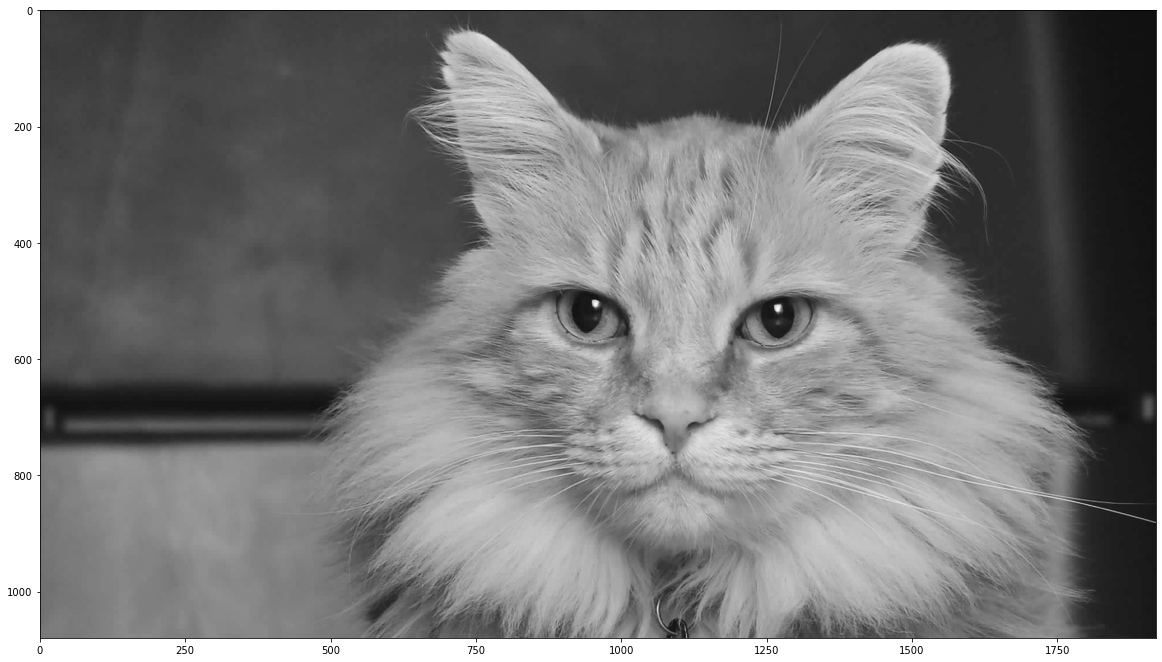

In [59]:
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table = LOW_COMPRESSION_MAT*2)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(20,20))
plt.imshow(ret_image, cmap ="gray");

#### RMSE is not good at all. We need to be selective about what components to increase. It could be because I modified the DC component. I will try to keep it as it is 
I will try to increase the qunatization value at the positions of high frequencies

## I have an idea! We can use zigzag in our design!
The problem can be complicated if we think about all the possible values in the matrix in 2D. However,<br>
We can think about it linearly. Since High Frequncy content is the thing we can sacrifice, <br>
we can use an increasing array of qunatization values, then transform it into a 2D qunatization table using ZigZag pattern

In [60]:
table = np.ones((64))
table[0:8] = 1
table[8:16] = 2
table[16:] = 256

qtble = np.empty((8,8))
qtble[ZIG_ZAG_ROW, ZIG_ZAG_COL] = table

In [61]:
qtble

array([[  1.,   1.,   1.,   1.,   2.,   2., 256., 256.],
       [  1.,   1.,   1.,   2., 256., 256., 256., 256.],
       [  1.,   2.,   2., 256., 256., 256., 256., 256.],
       [  2.,   2., 256., 256., 256., 256., 256., 256.],
       [  2., 256., 256., 256., 256., 256., 256., 256.],
       [256., 256., 256., 256., 256., 256., 256., 256.],
       [256., 256., 256., 256., 256., 256., 256., 256.],
       [256., 256., 256., 256., 256., 256., 256., 256.]])

Compression ratio is 10.581123670327273
The RMSE is 4.936424538299543


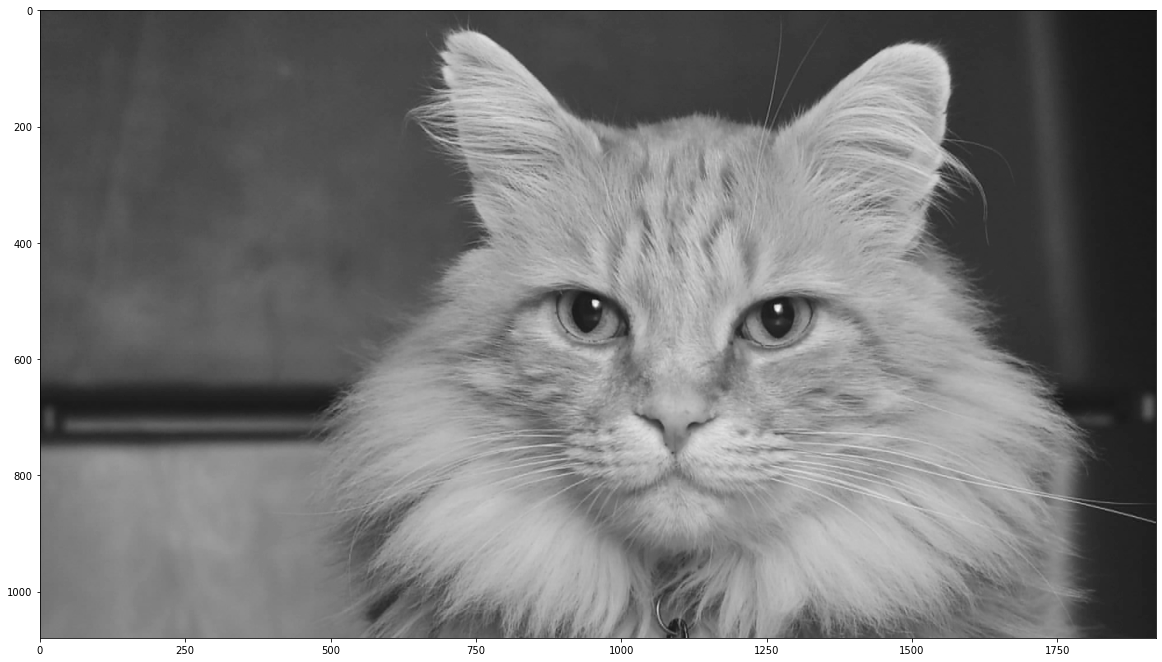

In [62]:
table = np.copy(LOW_COMPRESSION_MAT)
table[7, 0:3] = 128
table[7, 3:] = 256
table[0:3, 7] = 128
table[3:7, 7] = 256
table[2:, 2:] = 256
table = table * 2
table[0,0] /= 2
# encoding
hf_str, hf_tree, hf_dict, symb_dict,dims = encode_JPEG(hd_image, q_table = qtble)
# decoding
ret_image = decode_jpeg(hf_str, hf_tree, dims)
# Compression ratio:
print("Compression ratio is", dims[0]*dims[1]*8 / len(hf_str))
# RMSE
print("The RMSE is", np.sqrt(np.sum(np.power(ret_image-hd_image, 2))/dims[0]/dims[1]))
# Showing the image
plt.figure(figsize=(20,20))
plt.imshow(ret_image, cmap ="gray");

# Spec Achieved!!
and very low visual artefacts!

Now, we save the image file

In [63]:
gray_hd_ret = Image.fromarray(ret_image.astype(np.uint8))
gray_hd_ret.save("../Compressed_with_specs.jpeg")

# Image before compression is `Original_HD_grayscale.jpeg`
# Image after compression is `Compressed_with_specs.jpeg`

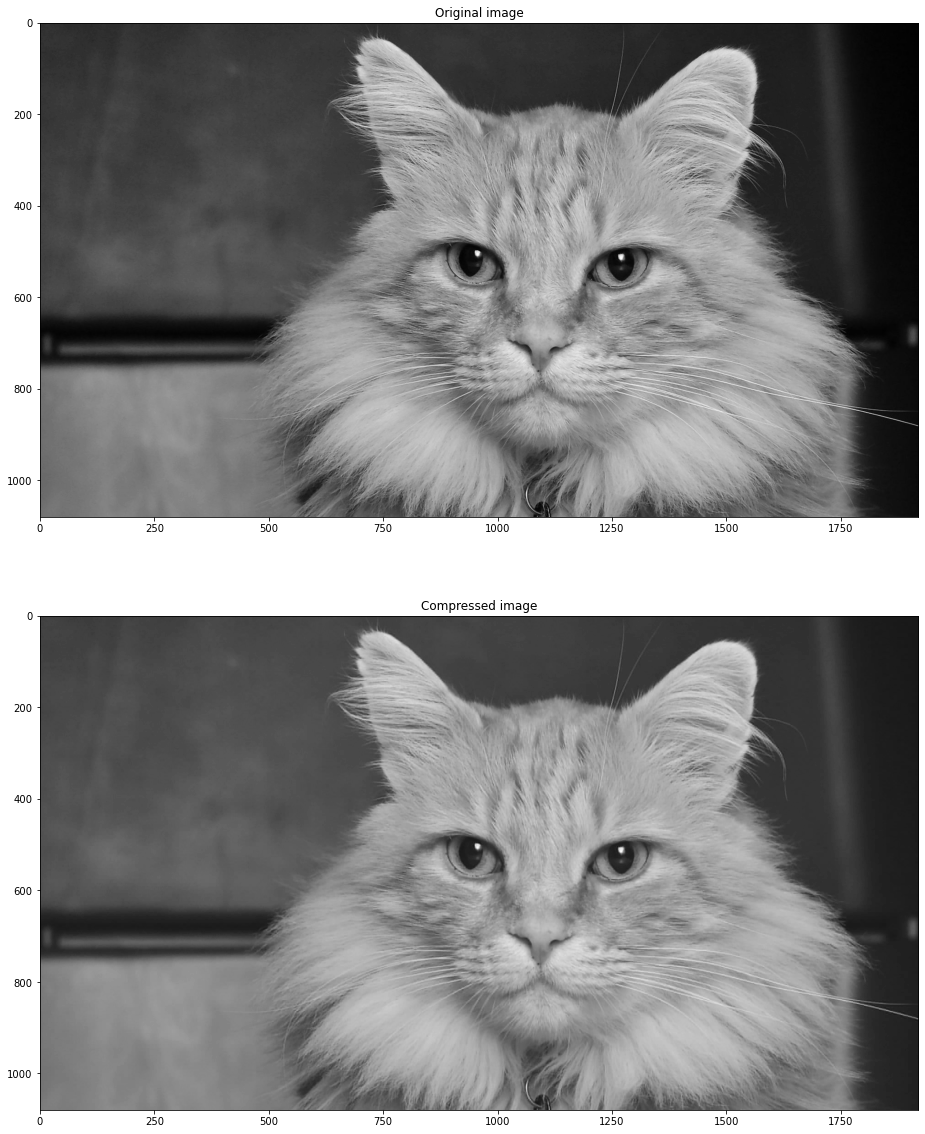

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,20));
ax1.imshow(hd_image, cmap = "gray");
ax1.set_title("Original image");
ax2.imshow(ret_image, cmap = "gray");
ax2.set_title("Compressed image");